# Tesla Stock Price Prediction - Model Comparison

## Objective
- Compare SimpleRNN vs LSTM performance across 1-day, 5-day, 10-day horizons
- Visualize actual vs predicted prices
- Provide insights and conclusions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

PROJECT_ROOT = Path('..').resolve()
DATA_PATH = PROJECT_ROOT / 'data' / 'processed'
MODELS_PATH = PROJECT_ROOT / 'models'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LSTM and SimpleRNN models to load saved weights
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions

class SimpleRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, dropout=0.2):
        super(SimpleRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        rnn_out = self.dropout(rnn_out)
        predictions = self.fc(rnn_out[:, -1, :])
        return predictions

In [3]:
comparison = []
horizons = [1, 5, 10]

for horizon in horizons:
    X_test = np.load(DATA_PATH / f'X_test_{horizon}d.npy')
    y_test = np.load(DATA_PATH / f'y_test_{horizon}d.npy')
    
    # Load SimpleRNN model
    rnn_model = SimpleRNNModel(input_size=1, hidden_size=50, output_size=1, dropout=0.2).to(device)
    rnn_model.load_state_dict(torch.load(MODELS_PATH / f'simple_rnn_{horizon}day_best.pt', map_location=device))
    rnn_model.eval()
    
    # Load LSTM model
    lstm_model = LSTMModel(input_size=1, hidden_size=64, output_size=1, dropout=0.2).to(device)
    lstm_model.load_state_dict(torch.load(MODELS_PATH / f'lstm_{horizon}day_best.pt', map_location=device))
    lstm_model.eval()
    
    # Make predictions
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    with torch.no_grad():
        rnn_pred = rnn_model(X_test_tensor).cpu().numpy()
        lstm_pred = lstm_model(X_test_tensor).cpu().numpy()
    
    rnn_mse = mean_squared_error(y_test, rnn_pred)
    lstm_mse = mean_squared_error(y_test, lstm_pred)
    
    comparison.append({
        'Horizon': f'{horizon}-day',
        'SimpleRNN_MSE': rnn_mse,
        'LSTM_MSE': lstm_mse,
        'Best': 'LSTM' if lstm_mse < rnn_mse else 'SimpleRNN'
    })

df_comp = pd.DataFrame(comparison)
print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)
print(df_comp.to_string(index=False))
print("="*60)


MODEL COMPARISON RESULTS
Horizon  SimpleRNN_MSE  LSTM_MSE      Best
  1-day       0.000390  0.000336      LSTM
  5-day       0.001335  0.001327      LSTM
 10-day       0.002431  0.002714 SimpleRNN


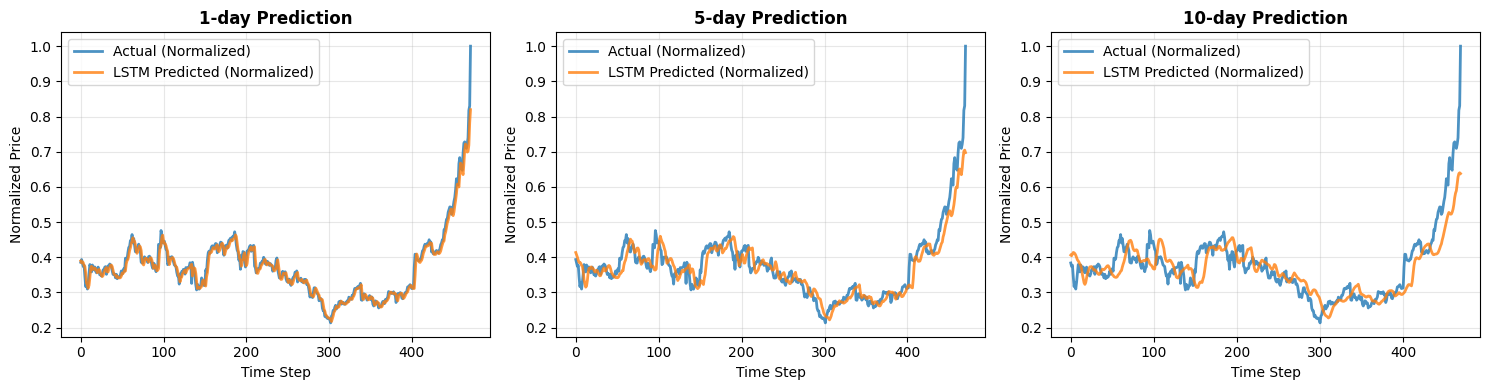


Visualization saved to: model_comparison.png


In [4]:
# Visualize predictions for each horizon
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, horizon in enumerate(horizons):
    X_test = np.load(DATA_PATH / f'X_test_{horizon}d.npy')
    y_test = np.load(DATA_PATH / f'y_test_{horizon}d.npy')
    
    # Load LSTM model for visualization
    lstm_model = LSTMModel(input_size=1, hidden_size=64, output_size=1, dropout=0.2).to(device)
    lstm_model.load_state_dict(torch.load(MODELS_PATH / f'lstm_{horizon}day_best.pt', map_location=device))
    lstm_model.eval()
    
    # Make predictions
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    with torch.no_grad():
        y_pred = lstm_model(X_test_tensor).cpu().numpy()
    
    # Plot normalized predictions (no scaler needed)
    axes[idx].plot(y_test, label='Actual (Normalized)', alpha=0.8, linewidth=2)
    axes[idx].plot(y_pred, label='LSTM Predicted (Normalized)', alpha=0.8, linewidth=2)
    axes[idx].set_title(f'{horizon}-day Prediction', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Normalized Price')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'notebooks' / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nVisualization saved to: model_comparison.png")